# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [16]:
import numpy as np
import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

In [17]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [18]:
import re
from random import shuffle
from glob import glob
train_files = glob('../input/train/*.jpg')
test_files = glob('../input/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

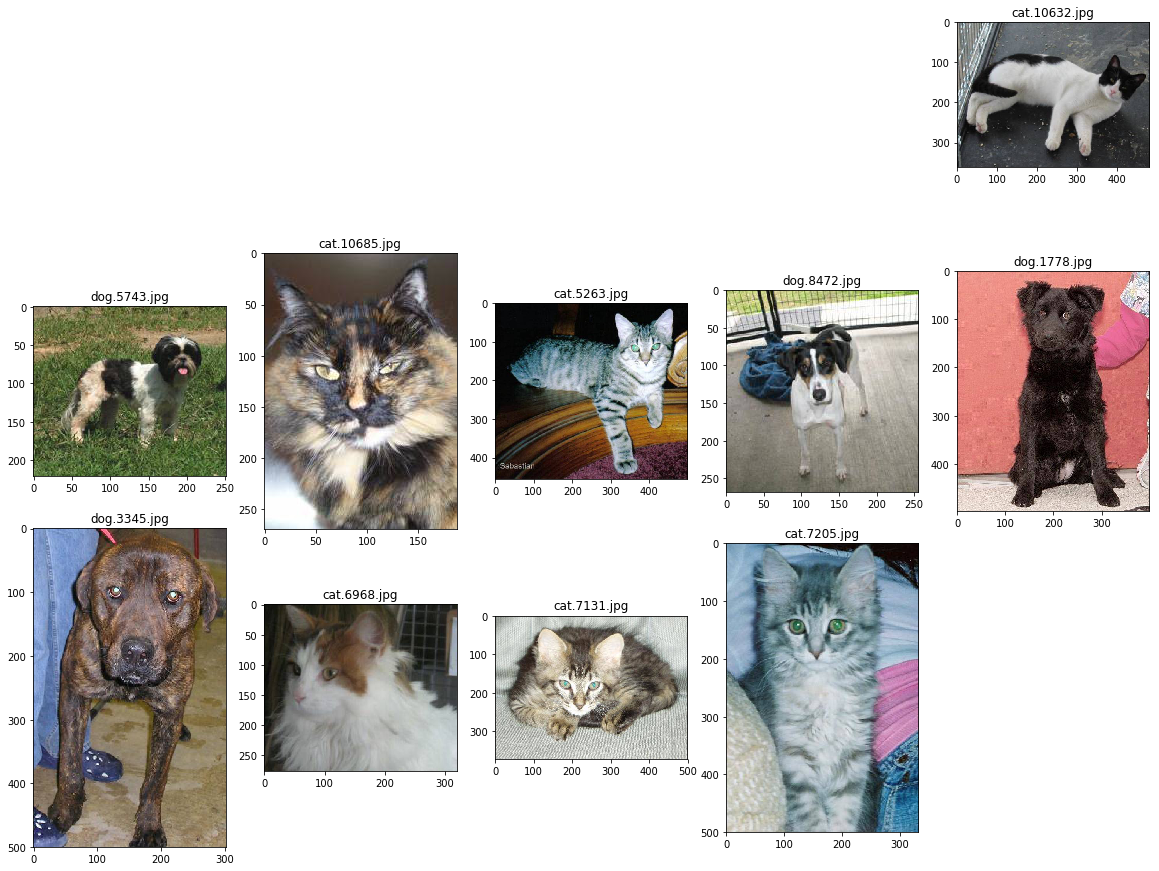

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);
plt.show()

## Загружаем предобученную модель

In [20]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [21]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [22]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Добавляем полносвязный слой

In [23]:
base_model.layers[-5].name

'block4_pool'

In [24]:
from keras.layers.normalization import BatchNormalization

In [72]:
x = base_model.layers[-5].output

x = keras.layers.Flatten()(x)

#x = keras.layers.normalization.BatchNormalization()(x)

#x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(386, activation='relu')(x)

x = keras.layers.normalization.BatchNormalization()(x) 

x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Компилируем модель и запускаем обучение

In [74]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [75]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=100,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 8s 778ms/step - loss: 1.0594 - acc: 0.7094 - val_loss: 0.7277 - val_acc: 0.7900
Epoch 2/100
10/10 [==============================] - 4s 408ms/step - loss: 0.4661 - acc: 0.8281 - val_loss: 0.5759 - val_acc: 0.8300
Epoch 3/100
10/10 [==============================] - 4s 408ms/step - loss: 0.4047 - acc: 0.8406 - val_loss: 0.4097 - val_acc: 0.8500
Epoch 4/100
10/10 [==============================] - 4s 411ms/step - loss: 0.3106 - acc: 0.8688 - val_loss: 0.2954 - val_acc: 0.8700
Epoch 5/100
10/10 [==============================] - 4s 410ms/step - loss: 0.2866 - acc: 0.8750 - val_loss: 0.2297 - val_acc: 0.9000
Epoch 6/100
10/10 [==============================] - 4s 411ms/step - loss: 0.3129 - acc: 0.8656 - val_loss: 0.1506 - val_acc: 0.9500
Epoch 7/100
10/10 [==============================] - 4s 410ms/step - loss: 0.2512 - acc: 0.9125 - val_loss: 0.1461 - val_acc: 0.9500
Epoch 8/100
10/10 [==============================] - 4s 410ms/step - 

10/10 [==============================] - 4s 412ms/step - loss: 0.1546 - acc: 0.9437 - val_loss: 0.1150 - val_acc: 0.9500
Epoch 63/100
10/10 [==============================] - 4s 410ms/step - loss: 0.1304 - acc: 0.9500 - val_loss: 0.1212 - val_acc: 0.9400
Epoch 64/100
10/10 [==============================] - 4s 411ms/step - loss: 0.1746 - acc: 0.9344 - val_loss: 0.1209 - val_acc: 0.9500
Epoch 65/100
10/10 [==============================] - 4s 410ms/step - loss: 0.1228 - acc: 0.9531 - val_loss: 0.1306 - val_acc: 0.9500
Epoch 66/100
10/10 [==============================] - 4s 410ms/step - loss: 0.1159 - acc: 0.9437 - val_loss: 0.0999 - val_acc: 0.9700
Epoch 67/100
10/10 [==============================] - 4s 412ms/step - loss: 0.1490 - acc: 0.9406 - val_loss: 0.0945 - val_acc: 0.9600
Epoch 68/100
10/10 [==============================] - 4s 409ms/step - loss: 0.1726 - acc: 0.9437 - val_loss: 0.1248 - val_acc: 0.9500
Epoch 69/100
10/10 [==============================] - 4s 411ms/step - loss:

In [77]:
model.save('cats_VS_dogs_5.10_386')

In [78]:
#from keras.models import load_model
#model = load_model('cats_VS_dogs_4.1')

## Предсказания на проверочной выборке

In [79]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

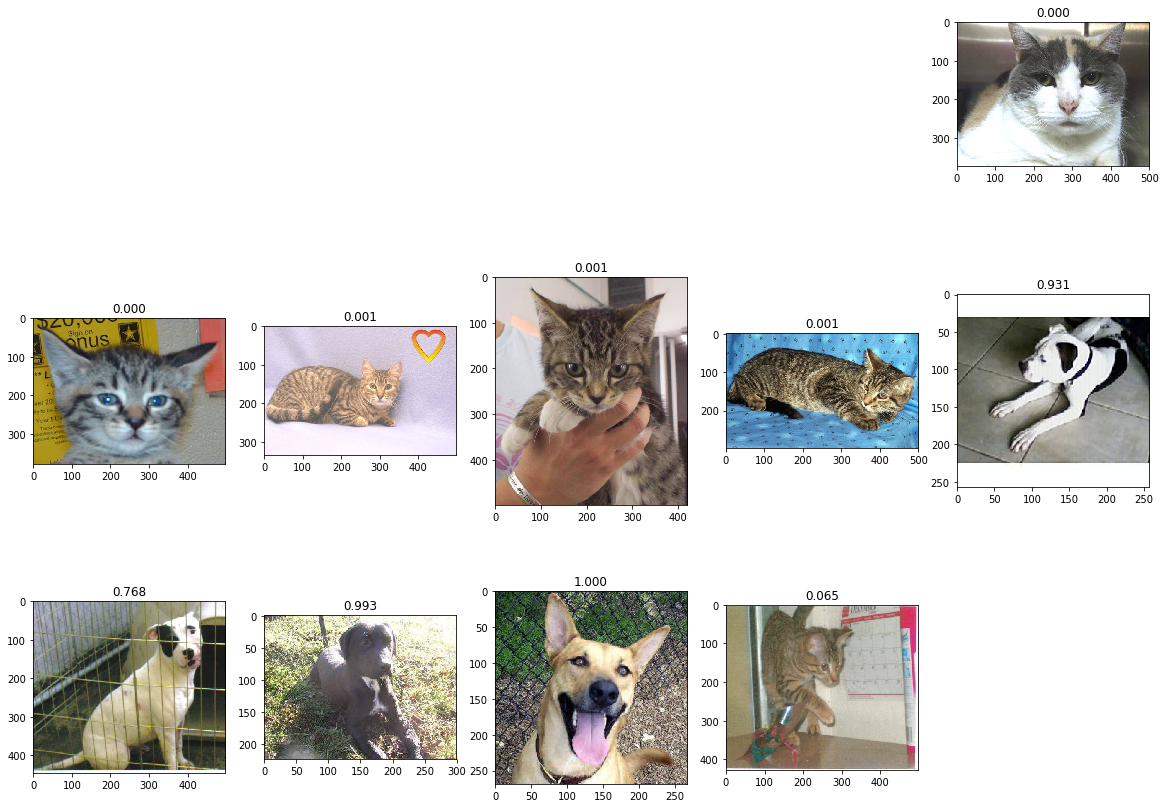

In [80]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[12480:][:10], pred[12480:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [81]:
with open('cats_VS_dogs_5.10_386.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%.1f\n' % (re.search('(\d+)', path).group(0), score))